# 教師あり学習(分類)

教師あり学習の課題はラベルづけされた学習用の例データ$\{y_i,x_i\}$から隠れた構造を推測することです。

分類とは出力値yが離散的な値をとる場合のタスクであることを意味します。

ここではEdwardを用いた例を示します。

# Data

observationsに含まれる[crab data set](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/crabs.html)を例として用います。これはいくつかの種類の蟹の形態学的な測定結果で構成されるデータセットです。ここではある蟹が青色(0で示される)なのかオレンジ色(1で示される)なのかを予測したいと思います。

In [10]:
import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs

In [11]:
data, metadata = crabs("~/data")
X_train = data[:100, 3:]
y_train = data[:100, 1]

N = X_train.shape[0]  # number of data points
D = X_train.shape[1]  # number of features

print("Number of data points: {}".format(N))
print("Number of features: {}".format(D))

>> Downloading /Users/apple/data/crabs.csv
>> [2.6 KB/2.6 KB] 38764% @1.1 GB/s,[0s remaining, 0s elapsed]        Number of data points: 100
Number of features: 5


In [28]:
X_test = data[100:, 3:]
y_test = data[100:, 1]

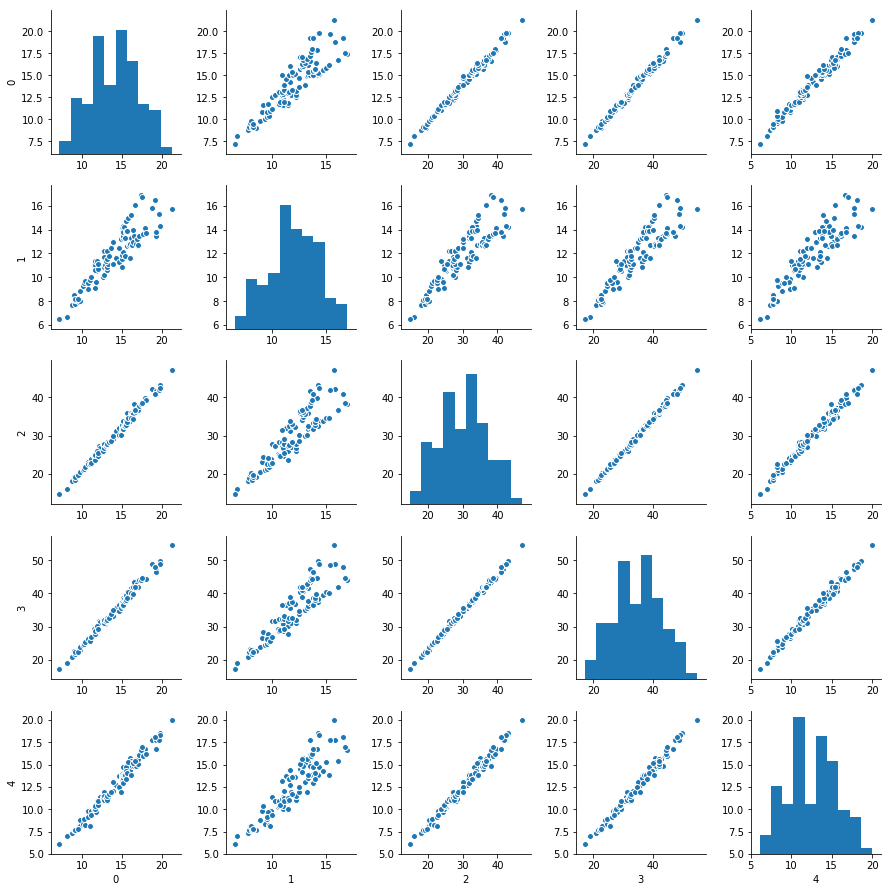

In [25]:
import seaborn as sns
import pandas as pd
%matplotlib inline
x=pd.DataFrame(X_train)
sns.pairplot(x)

# Model

ガウス過程(Gaussian Process)はランダムな変数間の非線型な関係を表現することのできる強力な手法です。
ガウス過程(大概は非線型な)関数空間上の分布として定義され、関数で書かれるような変数間の真の関係に近い不確かな関係を表現するのに使う事ができます。
ここでは分類に関するガウス過程を定義します([Rasumussen & Williams, 2006](http://www.gaussianprocess.org/gpml/)　を参考)。

形式的には平均が0、共分散関数がある任意の入力の組に対する依存性を表現し得るカーネル関数kでかける場合、関数$f:R^D \rightarrow R$の分布はガウス過程

$p(f)=\mathcal{GP}(f|0,k(x,x'))$

で書くことができます。

ある入出力の組${x_n \in R^D ,y_n \in R }$が与えられた時、その尤度は多変量正規分布

$p(y)=Normal(y | 0, K)$

で書くことができ、共分散行列Kの(n,m)番目の要素はデータセットに含まれる入力値の組$x_n,x_m$とカーネル関数kを使って$k(x_n,x_m)$と書かれるような値です。
上記の事実は分類、即ち$y \in \{0,1\}$が２値の場合と同様にyが実数値を取る回帰の場合にもそのまま適用することができます。

ここでは分類を扱うために隠れた変数を　$[0,1]$の区間内に押し込めるような処理が必要になります。（２値）ラベルの確率が$[0,1]$に入るようにするためにベルヌーイ(Bernoulli)分布から値を取りだすこととします。

観測された量$(x_n,y_n)$の尤度を

$p(y_n|z,x_n)=Bernoulli(y_n|  logit^{-1}(x_n^T z) )$
と定義し、
事前分布を多変量正規分布

$p(z)=Normal(z|0,K)$

として定義します。共分散行列Kは上で説明したものです。

Edwardでモデルを構築してみましょう。ここでは動径基底関数(RBF)カーネル、またの名を２次指数関数を使います。これはカーネル行列をデータ点の全ての組に対して適用したものです。ここでCholesky分解を用いると行列を多変量正規分布を使って（以下のように)分解することができます。

In [14]:
from edward.models import Bernoulli, MultivariateNormalTriL
from edward.util import rbf

X = tf.placeholder(tf.float32, [N, D])
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
y = Bernoulli(logits=f)

ここでプレースホルダーXを定義しました。推測計算の間データに相当する値はこのプレースホルダーに渡されます。

# 推測

変分推測を行います。変分モデル(q)を完全に因子分解された正規分布として定義します。

In [15]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

変分推測を５００回イテレーションします。

In [16]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 82.715


この場合KLqpはデフォルトでは取り直されたパラメータの勾配(reparameterization gradient)を使って $\text{KL}(q\|p)$ を最小化します。
推測処理の詳細は $\text{KL}(q\|p)$のチュートリアルを参照してください。
(またこの例ではガウス過程の共分散全体を評価して逆行列を取ることになるので計算が遅くなります。)

# Criticism

In [26]:
y_post = ed.copy(y, {f: qf})

In [30]:
print("Mean squared error on test data:") #テストデータに対する二乗誤差
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:") #テストデータに対する誤差の絶対値
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.02
Mean absolute error on test data:
0.02


# References

Rasmussen, C. E., & Williams, C. (2006). [Gaussian processes for machine learning](http://www.gaussianprocess.org/gpml/). MIT Press.